In [1]:
import pandas as pd
from bda.utils import plot_beta_binomial, plot_gamma_poisson, mcmc_stan, mcmc_trace, mcmc_hist, mcmc_dens, neff_ratio, mcmc_acf, rhat
import scipy.stats as stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 6.1 Grid approximation

## 6.1.1 A Beta-Binomial example

Als Beispiel für die Grid-Approximation wird folgendes Setting verwendet:

$$Y 
\mid \pi \sim \text{Bin}(10, \pi)\\
\quad \pi \sim \text{Beta}(2, 2)
$$


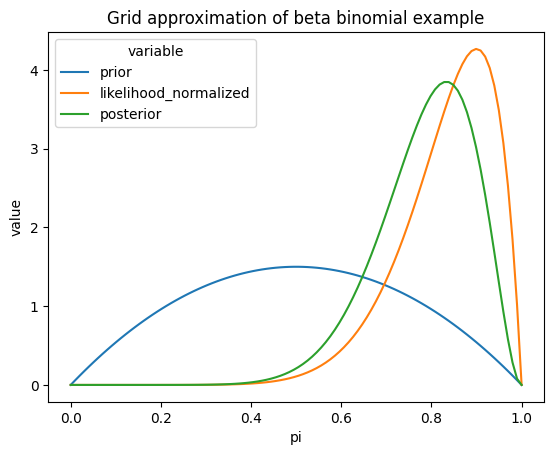

In [2]:
df = pd.DataFrame({
    "pi": np.linspace(0, 1, 100)
})

df["prior"] = stats.beta.pdf(a=2, b=2, x=df.pi)
df["likelihood"] = stats.binom.pmf(k=9, n=10, p=df.pi)
df["likelihood_normalized"] = df.likelihood / np.trapezoid(df.likelihood, df.pi)
df["unnormalized"] = df.prior*df.likelihood
df["posterior"] = df.unnormalized / np.trapezoid(df.unnormalized, df.pi)

sns.lineplot(df[["pi", "prior", "likelihood_normalized", "posterior"]].melt("pi"), x="pi", y="value", hue="variable")
plt.title("Grid approximation of beta binomial example")
plt.show()

Noch zum Check:

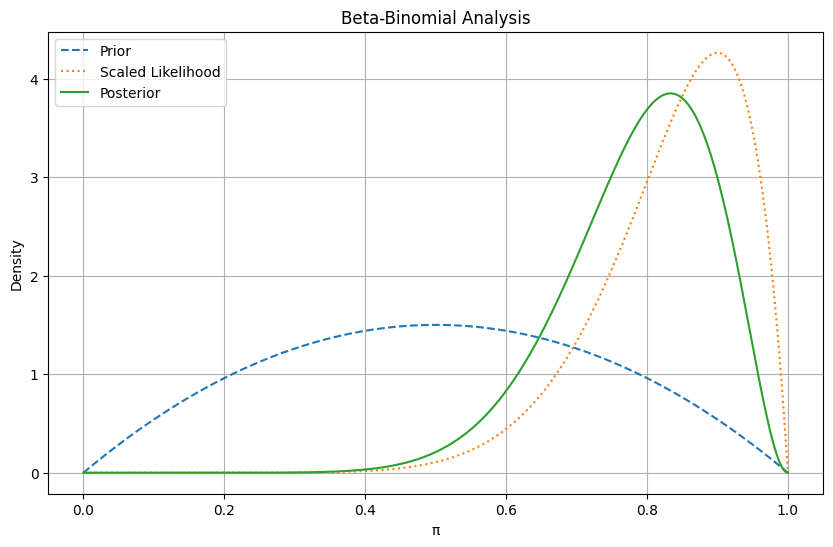

In [3]:
plot_beta_binomial(2, 2, 10, 9)

## 6.1.2 A Gamma-Poisson example

Und non folgendes Beispiel:

$$Y_i \mid \lambda \overset{\text{ind}}{\sim} \text{Pois}(\lambda) \\ \quad \lambda \sim \text{Gamma}(3, 1)$$


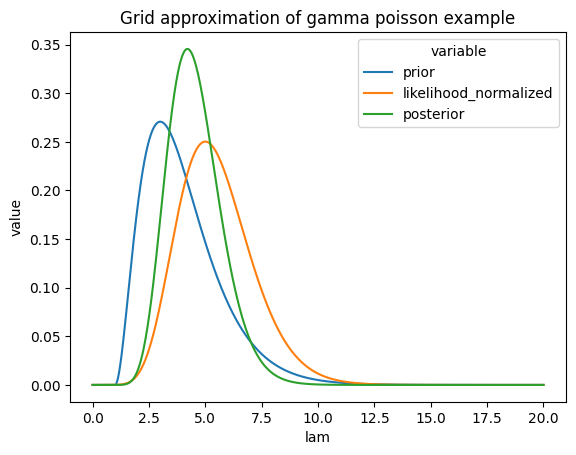

In [4]:
df = pd.DataFrame({
    "lam": np.linspace(0, 20, 1000)
})
df["prior"] = stats.gamma(3, 1).pdf(df.lam)
df["likelihood"] = stats.poisson.pmf(8, df.lam) * stats.poisson.pmf(2, df.lam)
df["likelihood_normalized"] = df.likelihood / np.trapezoid(df.likelihood, df.lam)
df["unnormalized"] = df.prior*df.likelihood
df["posterior"] = df.unnormalized / np.trapezoid(df.unnormalized, df.lam)

sns.lineplot(df[["lam", "prior", "likelihood_normalized", "posterior"]].melt("lam"), x="lam", y="value", hue="variable")
plt.title("Grid approximation of gamma poisson example")
plt.show()

Und nun noch zum Vergleich:

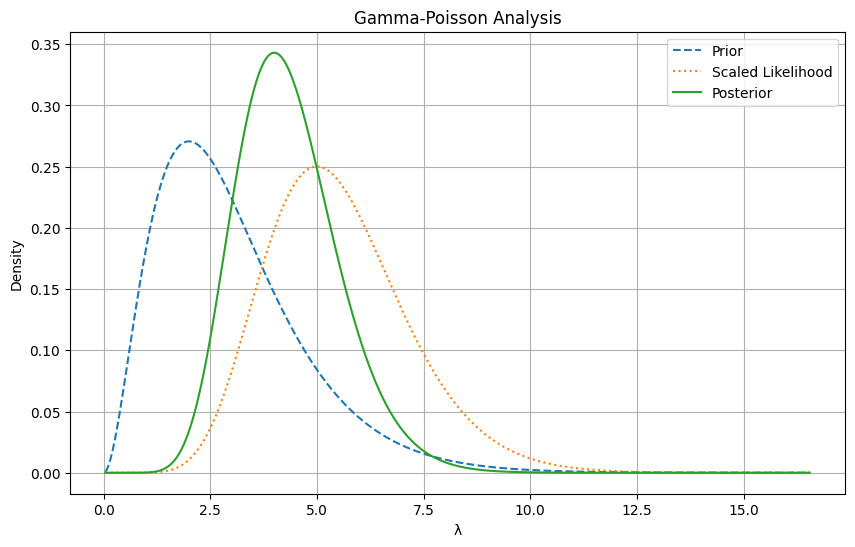

In [5]:
plot_gamma_poisson(3, 1, 10, 2)

## Kritik

Grid-Approximation leidet unter Curse-Of-Dimensionality (hauptsächlich wenn Posterior multivariat ist!)

# 6.2 Markov chains via rstan

## 6.2.1 A Beta-Binomial example

In [6]:
bb_model = """
  data {
  
    int<lower = 0, upper = 10> Y;
  }
  parameters {
    real<lower = 0, upper = 1> pi;
  }
  model {
    Y ~ binomial(10, pi);
    pi ~ beta(2, 2);
  }
"""

data = {
    "Y": 9
}

bb_results = mcmc_stan(bb_model, data, save_warmup=False)

bb_results

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!


,chain_0,chain_1,chain_2,chain_3,sample_nr,var_name,is_warmup
0,0.530312,0.713263,0.735355,0.789940,0,pi,False
1,0.659308,0.817129,0.835666,0.901621,1,pi,False
2,0.754275,0.671726,0.903560,0.918595,2,pi,False
3,0.608567,0.902146,0.881601,0.911189,3,pi,False
4,0.684760,0.631389,0.874007,0.816432,4,pi,False
...,...,...,...,...,...,...,...
9995,0.885211,0.645718,0.679007,0.852221,9995,pi,False
9996,0.603955,0.802399,0.786413,0.639329,9996,pi,False
9997,0.878416,0.705093,0.833125,0.699852,9997,pi,False
9998,0.847161,0.739588,0.849179,0.733843,9998,pi,False


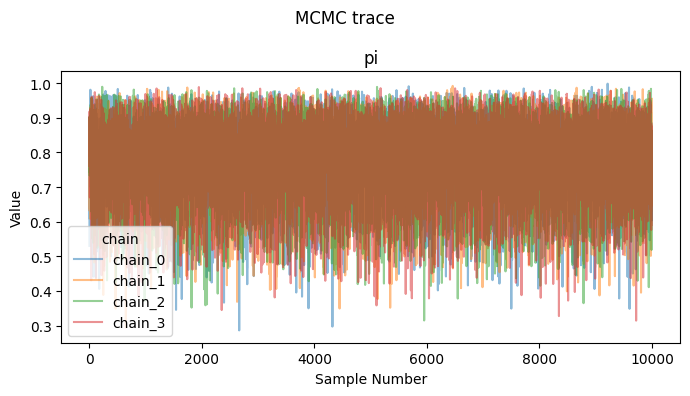

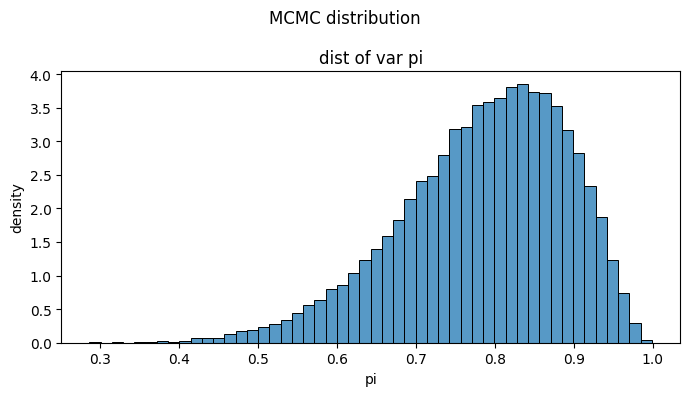

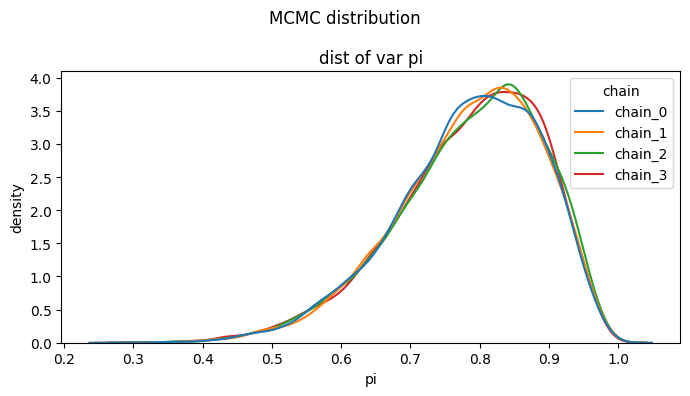

In [7]:
mcmc_trace(bb_results)
mcmc_hist(bb_results, stat="density")
mcmc_dens(bb_results)

Die chains haben sich gut eingependelt. Es ist kein Trend mehr sichtbar und die Chain hört auch nicht auf zu lernen. Alle Chains sehen etwa gleich aus, was auch auf eine stabile Simulation deutet.

Überprüfe Resultat:

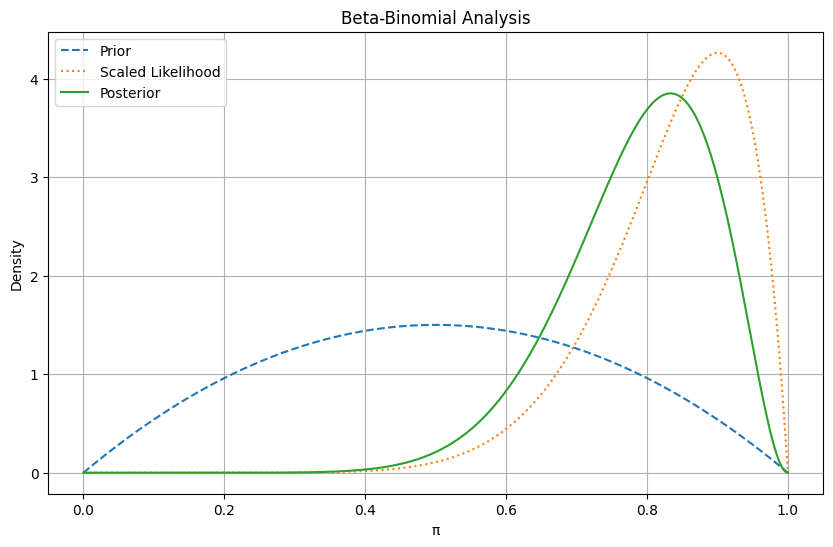

In [8]:
plot_beta_binomial(2,2, 10, 9)

## 6.2.2 A Gamma-Poisson example

In [9]:
gp_model = """
  data {
    array[2] int<lower = 0> Y;
  }
  parameters {
    real<lower = 0> lambda;
  }
  model {
    Y ~ poisson(lambda);
    lambda ~ gamma(3, 1);
  }
"""

data = {
    "Y": [2, 8]
}

gp_results = mcmc_stan(gp_model, data)

gp_results

Building...



Building: found in cache, done.Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_s2k4vhrn/model_6c72naka.stan', line 10, column 4 to column 25)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 3e-06 seconds
  1000 tra

,chain_0,chain_1,chain_2,chain_3,sample_nr,var_name,is_warmup
0,4.881159,2.861680,5.131072,4.479112,0,lambda,False
1,4.073733,4.247760,6.148850,4.425380,1,lambda,False
2,3.355549,5.617659,4.877062,5.471433,2,lambda,False
3,4.905237,4.126642,4.249444,4.176627,3,lambda,False
4,2.628601,4.059144,4.635842,4.132834,4,lambda,False
...,...,...,...,...,...,...,...
9995,5.617184,4.119912,3.105457,3.499167,9995,lambda,False
9996,5.527165,3.099736,5.037052,4.123713,9996,lambda,False
9997,6.363649,5.007679,4.754953,3.374976,9997,lambda,False
9998,5.519735,8.015792,3.147761,7.215002,9998,lambda,False


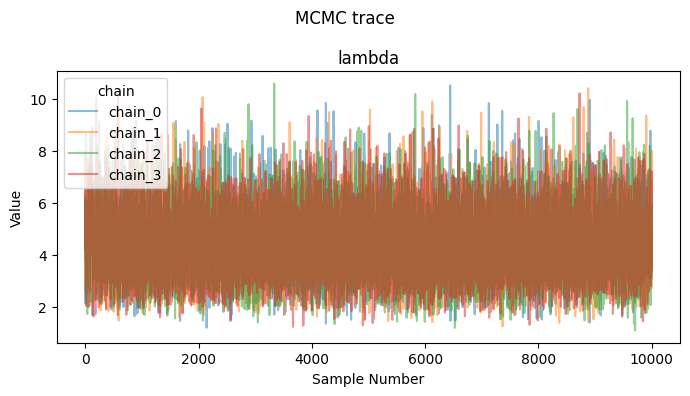

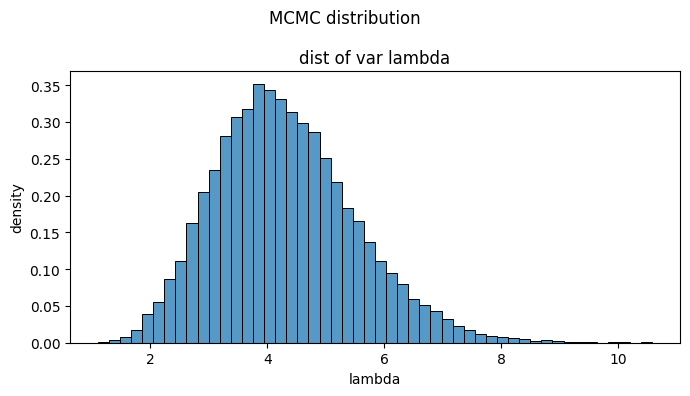

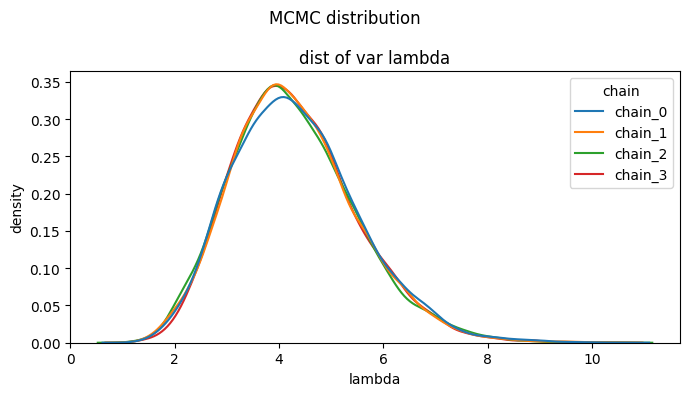

In [10]:
mcmc_trace(gp_results)
mcmc_hist(gp_results, stat="density")
mcmc_dens(gp_results)

Die chains haben sich gut eingependelt. Es ist kein Trend mehr sichtbar und die Chain hört auch nicht auf zu lernen. Alle Chains sehen etwa gleich aus, was auch auf eine stabile Simulation deutet.

Überprüfe Resultat:

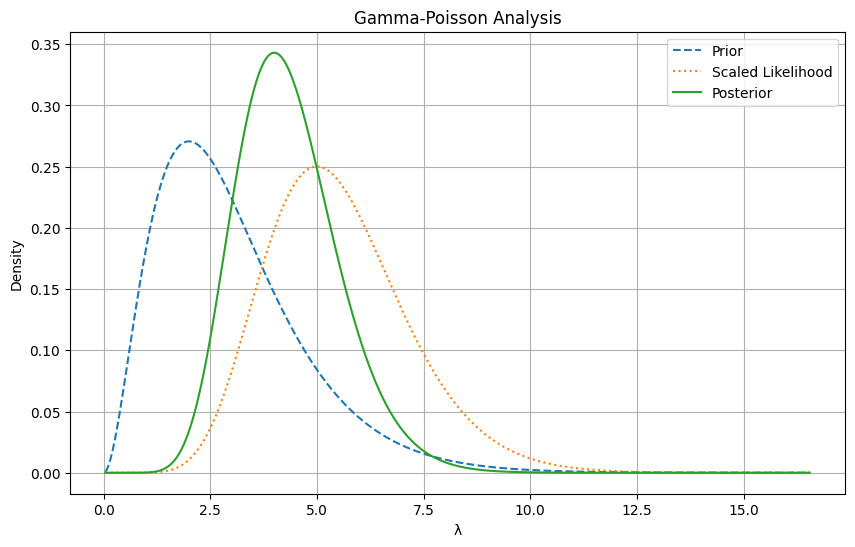

In [11]:
plot_gamma_poisson(3, 1, 10, 2)

# 6.3.3 Calculating effective sample size & autocorrelation

In [12]:

bb_model = """
  data {
  
    int<lower = 0, upper = 10> Y;
  }
  parameters {
    real<lower = 0, upper = 1> pi;
  }
  model {
    Y ~ binomial(10, pi);
    pi ~ beta(2, 2);
  }
"""

data = {
    "Y": 9
}

bb_results = mcmc_stan(bb_model, data)

bb_results

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!


,chain_0,chain_1,chain_2,chain_3,sample_nr,var_name,is_warmup
0,0.530312,0.713263,0.735355,0.789940,0,pi,False
1,0.659308,0.817129,0.835666,0.901621,1,pi,False
2,0.754275,0.671726,0.903560,0.918595,2,pi,False
3,0.608567,0.902146,0.881601,0.911189,3,pi,False
4,0.684760,0.631389,0.874007,0.816432,4,pi,False
...,...,...,...,...,...,...,...
9995,0.885211,0.645718,0.679007,0.852221,9995,pi,False
9996,0.603955,0.802399,0.786413,0.639329,9996,pi,False
9997,0.878416,0.705093,0.833125,0.699852,9997,pi,False
9998,0.847161,0.739588,0.849179,0.733843,9998,pi,False


In [13]:
neff_ratio(bb_results)

,n_draws,n_chains,ess,ess_ratio
var_name,,,,
pi,10000,4,14263.149811,0.356579


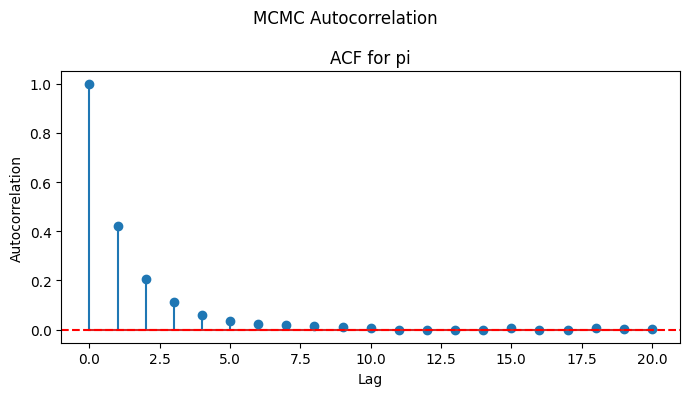

In [14]:
mcmc_acf(bb_results)

In [15]:
rhat(bb_results)

,rhat,n_chains
var_name,,
pi,1.000083,4
